https://qiita.com/satolab/items/8efa513e7fd6cb41fdc5

##ライブラリをインポート

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## データセットの設定

In [ ]:
#バッチサイズを指定
BATCH_SIZE = 100
#訓練データと試験データの比率
train_rate=0.8# 8割を訓練
test_rate=0.2# 2割をテスト

#MNISTを読込
trainval_data = MNIST("./data",
                   train=True,
                   download=True,
                   transform=transforms.ToTensor())
#データセットの設定
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

#訓練データセットを生成
train_loader = DataLoader(dataset=train_data,#データセットの設定
                          batch_size=BATCH_SIZE,#バッチサイズの指定
                          shuffle=True,#抽出時にシャッフル
                          num_workers=0)# 並列実行数

#試験データセットを生成
val_loader = DataLoader(dataset=val_data,#データセットの設定
                        batch_size=BATCH_SIZE,#バッチサイズの指定
                        shuffle=True,#抽出時にシャッフル
                        num_workers=0)# 並列実行数

#可視化
print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120

100%|██████████| 9912422/9912422 [00:00<00:00, 106215475.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105243869.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26211848.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14345277.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


### データの可視化

images_size: torch.Size([100, 1, 28, 28])
label: tensor([6, 1, 7, 4, 1, 7, 5, 3, 9, 3])


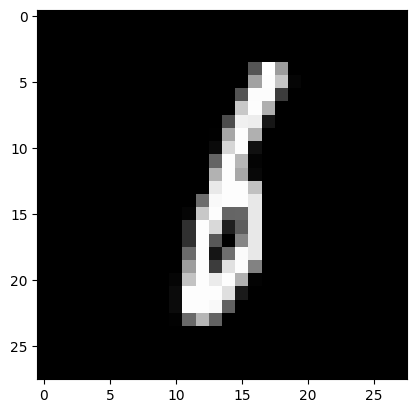

In [ ]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

## オートエンコーダAE

###ネットワーク生成

In [ ]:
class Encoder_AE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)#結合層(入力画像⇒300次元配列)
    self.lr2 = nn.Linear(300, 100)#結合層(300次元配列⇒100次元配列)
    self.lr3 = nn.Linear(100, z_dim)#結合層(100次元配列⇒2次元配列)
    self.relu = nn.ReLU()#活性化関数の層

  def forward(self, x):
    x = self.lr(x)#画像⇒300次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr2(x)#300次元配列⇒100次元配列
    x = self.relu(x)#ReLu関数で活性化
    z = self.lr3(x)#100次元配列⇒潜在変数

    return z

class Decoder_AE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)#結合層(潜在変数⇒100次元配列)
    self.lr2 = nn.Linear(100, 300)#結合層(100次元配列⇒300次元配列)
    self.lr3 = nn.Linear(300, 28*28)#結合層(300次元配列⇒復元画像)
    self.relu = nn.ReLU()#活性化関数の層

  def forward(self, z):
    x = self.lr(z)#潜在変数⇒100次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr2(x)#100次元配列⇒300次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr3(x)#300次元配列⇒復元画像
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class AE(nn.Module):
  def __init__(self, z_dim):
    """
    #################################################################
    Variables:
      -x_in: 入力画像
      -x_out: 入力画像
      -z: 潜在変数
    #################################################################
    """
    super().__init__()
    self.encoder = Encoder_AE(z_dim)
    self.decoder = Decoder_AE(z_dim)

  def forward(self, x_in):
    z = self.encoder(x_in)#エンコーダ
    x_out = self.decoder(z)#デコーダ
    return x_out, z

###損失関数

In [ ]:
def criterion(predict, target):
  """
  #################################################################
  Variables:
    -target:
    -predict:
  #################################################################
  """
  # 潜在ロス： クロスエントロピー
  loss = F.binary_cross_entropy(predict, target, reduction='sum')
  return loss

### 学習

In [ ]:
#変数定義
z_dim = 2 #潜在変数の次元数
num_epochs = 20 #エポック数
#学習の設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# 使用するデバイス
model = AE(z_dim).to(device)#　学習モデル
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#　最適化関数
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)#スケジューラ

#history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}#学習結果保存用の配列
history_AE = {"val_loss": [], "train_loss": [], "z": [], "labels":[]}#学習結果保存用の配列

for epoch in range(num_epochs):
  #訓練データの学習
  model.train()#モデルの選択
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z = model(input)
    #学習結果を保存
    history_AE["z"].append(z)
    history_AE["labels"].append(labels)
    loss = criterion(output, input)
    #最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #途中過程の出力
    #if (i+1) % 50 == 0:
      #print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    #損失関数の結果を保存
    history_AE["train_loss"].append(loss)

  ##テストデータの学習
  model.eval()#モデルの選択
  with torch.no_grad():#メモリ削減のおまじない
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z = model(input)
      #損失関数および結果の保存
      loss = criterion(output, input)
      history_AE["val_loss"].append(loss)
    #途中過程の出力
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')

  scheduler.step()

Epoch: 1, val_loss:  16468.0859
Epoch: 2, val_loss:  16000.8320
Epoch: 3, val_loss:  15165.8984
Epoch: 4, val_loss:  13999.7217
Epoch: 5, val_loss:  13930.5547
Epoch: 6, val_loss:  14934.2539
Epoch: 7, val_loss:  13442.5273
Epoch: 8, val_loss:  13384.5605
Epoch: 9, val_loss:  13623.0508
Epoch: 10, val_loss:  14270.0518
Epoch: 11, val_loss:  13735.2451
Epoch: 12, val_loss:  13600.0469
Epoch: 13, val_loss:  14055.7168
Epoch: 14, val_loss:  13648.2520
Epoch: 15, val_loss:  13722.5693
Epoch: 16, val_loss:  14327.5391
Epoch: 17, val_loss:  13380.6885
Epoch: 18, val_loss:  13461.4727
Epoch: 19, val_loss:  14231.3301
Epoch: 20, val_loss:  12744.3086


## 変分オートエンコーダVAE

### ネットワーク生成

In [ ]:
class Encoder_VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)#結合層(1層目)
    self.lr2 = nn.Linear(300, 100)#結合層(2層目)
    self.lr_ave = nn.Linear(100, z_dim)#平均値を求める層
    self.lr_dev = nn.Linear(100, z_dim)#分散を求める層
    self.relu = nn.ReLU()#活性化関数の層

  def forward(self, x):
    x = self.lr(x)#画像⇒300次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr2(x)#300次元配列⇒100次元配列
    x = self.relu(x)#ReLu関数で活性化
    ave = self.lr_ave(x)#100次元配列⇒平均
    log_dev = self.lr_dev(x)#100次元配列⇒分散

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder_VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)#結合層(潜在変数⇒100次元配列)
    self.lr2 = nn.Linear(100, 300)#結合層(300次元配列⇒100次元配列)
    self.lr3 = nn.Linear(300, 28*28)#結合層(300次元配列⇒復元画像)
    self.relu = nn.ReLU()#活性化関数の層

  def forward(self, z):
    x = self.lr(z)#潜在変数⇒100次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr2(x)#100次元配列⇒300次元配列
    x = self.relu(x)#ReLu関数で活性化
    x = self.lr3(x)#300次元配列⇒復元画像
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    """
    #################################################################
    Variables:
      -x_in: 入力画像
      -x_out: 入力画像
      -z: 潜在変数
      -ave: 平均値
      -log_dev: 分散(対数値)
    #################################################################
    """
    super().__init__()
    self.encoder = Encoder_VAE(z_dim)
    self.decoder = Decoder_VAE(z_dim)

  def forward(self, x_in):
    z, ave, log_dev = self.encoder(x_in)#エンコーダ
    x_out = self.decoder(z)#デコーダ
    return x_out, z, ave, log_dev

### 損失関数

In [ ]:
def criterion(predict, target, ave, log_dev):
  """
  #################################################################
  Variables:
    -target:
    -predict:
    -ave: 平均値
    -log_dev: 分散(対数値)
  #################################################################
  """
  # 潜在ロス： クロスエントロピー
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  # 再構築ロス（BCE誤差の平均値）：E(w)=-1/NΣN(tlog(x)+(1-t)log(1-x))
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  # 再構成ロス + 潜在ロス
  loss = bce_loss + kl_loss
  return loss

### 学習

In [ ]:
#変数定義
z_dim = 2 #潜在変数の次元数
num_epochs = 20 #エポック数
#学習の設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# 使用するデバイス
model = VAE(z_dim).to(device)#　学習モデル
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#　最適化関数
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)#スケジューラ

history_VAE = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}#学習結果保存用の配列

for epoch in range(num_epochs):
  #訓練データの学習
  model.train()#モデルの選択
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)
    #学習結果を保存
    history_VAE["ave"].append(ave)
    history_VAE["log_dev"].append(log_dev)
    history_VAE["z"].append(z)
    history_VAE["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
    #最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #途中過程の出力
    #if (i+1) % 50 == 0:
      #print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    #損失関数の結果を保存
    history_VAE["train_loss"].append(loss)

  ##テストデータの学習
  model.eval()#モデルの選択
  with torch.no_grad():#メモリ削減のおまじない
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)
      #損失関数および結果の保存
      loss = criterion(output, input, ave, log_dev)
      history_VAE["val_loss"].append(loss)
    #途中過程の出力
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')

  scheduler.step()

Epoch: 1, val_loss:  15768.9111
Epoch: 2, val_loss:  16386.8691
Epoch: 3, val_loss:  15850.0117
Epoch: 4, val_loss:  15463.3516
Epoch: 5, val_loss:  14991.7354
Epoch: 6, val_loss:  14573.1172
Epoch: 7, val_loss:  14537.8633
Epoch: 8, val_loss:  15851.1338
Epoch: 9, val_loss:  14433.4961
Epoch: 10, val_loss:  15229.3262
Epoch: 11, val_loss:  14920.4951
Epoch: 12, val_loss:  14727.1758
Epoch: 13, val_loss:  14222.7188
Epoch: 14, val_loss:  14766.7119
Epoch: 15, val_loss:  14664.6689
Epoch: 16, val_loss:  13959.0010
Epoch: 17, val_loss:  14105.4395
Epoch: 18, val_loss:  14126.4150
Epoch: 19, val_loss:  14063.0371
Epoch: 20, val_loss:  13959.1631


##結果を描画
###学習損失

Text(0.0, 1.0, 'VAE_Test')

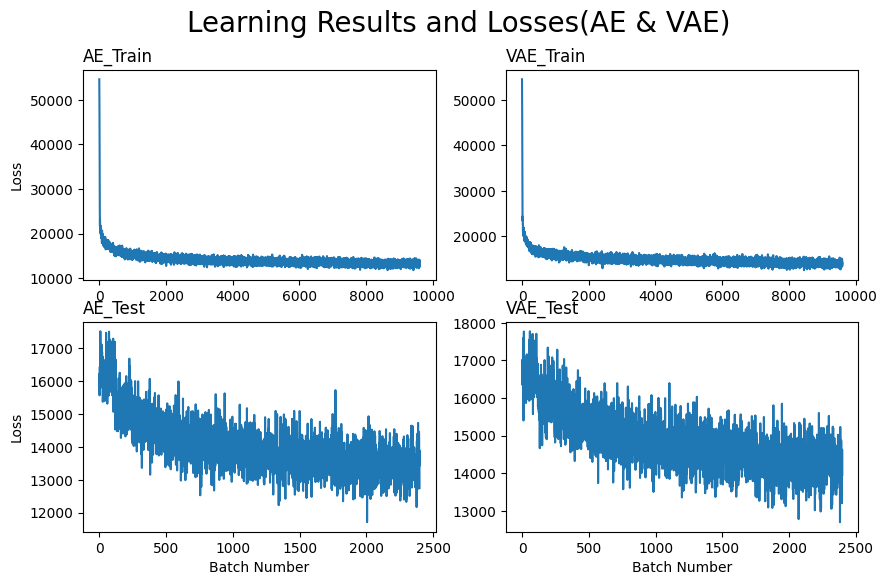

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.suptitle('Learning Results and Losses(AE & VAE)',fontsize=20)

train_loss_tensor = torch.stack(history_AE["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(train_loss_np)
ax1.set_ylabel("Loss")
ax1.set_title("AE_Train", loc='left')

val_loss_tensor = torch.stack(history_AE["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(val_loss_np)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Batch Number")
ax2.set_title("AE_Test", loc='left')

train_loss_tensor = torch.stack(history_VAE["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
ax3 = fig.add_subplot(2, 2, 2)
ax3.plot(train_loss_np)
#ax3.set_ylabel("Loss")
ax3.set_title("VAE_Train", loc='left')

val_loss_tensor = torch.stack(history_VAE["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(val_loss_np)
#ax4.set_ylabel("Loss")
ax4.set_xlabel("Batch Number")
ax4.set_title("VAE_Test", loc='left')


### historyから潜在変数とラベルを取得

### AE

In [ ]:
z_tensor_AE = torch.stack(history_AE["z"])
labels_tensor_AE = torch.stack(history_AE["labels"])
print(z_tensor_AE.size())   #torch.Size([9600, 100, 2])
print(labels_tensor_AE.size())   #torch.Size([9600, 100])

z_np_AE = z_tensor_AE.to('cpu').detach().numpy().copy()
labels_np_AE = labels_tensor_AE.to('cpu').detach().numpy().copy()
print(z_np_AE.shape)   #(9600, 100, 2)
print(labels_np_AE.shape)   #(9600, 100)

torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100)


### VAE

In [ ]:
ave_tensor_VAE = torch.stack(history_VAE["ave"])
log_var_tensor_VAE = torch.stack(history_VAE["log_dev"])
z_tensor_VAE = torch.stack(history_VAE["z"])
labels_tensor_VAE = torch.stack(history_VAE["labels"])
print(ave_tensor_VAE.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor_VAE.size())   #torch.Size([9600, 100, 2])
print(z_tensor_VAE.size())   #torch.Size([9600, 100, 2])
print(labels_tensor_VAE.size())   #torch.Size([9600, 100])

ave_np_VAE = ave_tensor_VAE.to('cpu').detach().numpy().copy()
log_var_np_VAE = log_var_tensor_VAE.to('cpu').detach().numpy().copy()
z_np_VAE = z_tensor_VAE.to('cpu').detach().numpy().copy()
labels_np_VAE = labels_tensor_VAE.to('cpu').detach().numpy().copy()
print(ave_np_VAE.shape)   #(9600, 100, 2)
print(log_var_np_VAE.shape)   #(9600, 100, 2)
print(z_np_VAE.shape)   #(9600, 100, 2)
print(labels_np_VAE.shape)   #(9600, 100)

torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100, 2)
(9600, 100, 2)
(9600, 100)


###潜在変数空間

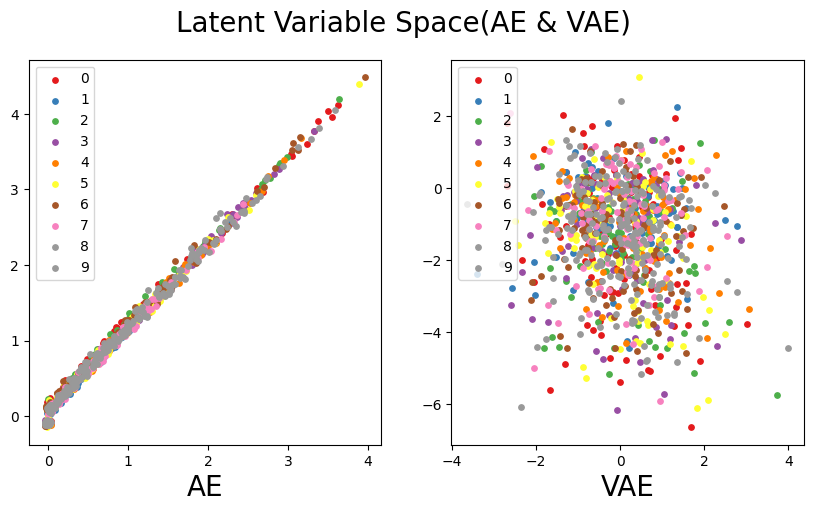

In [ ]:
#グラフの色の指定
map_keyword = "Set1"
cmap = plt.get_cmap(map_keyword)

#表示するバッチ番号の指定
batch_num =10

#グラフの設定
fig=plt.figure(figsize=[10,5])
plt.suptitle('Latent Variable Space(AE & VAE)',fontsize=20)

train_loss_tensor = torch.stack(history_AE["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
ax1 = fig.add_subplot(1, 2, 1)
for label in range(10):
  x = z_np_AE[:batch_num,:,0][labels_np_AE[:batch_num,:] == label]
  y = z_np_AE[:batch_num,:,1][labels_np_AE[:batch_num,:] == label]
  ax1.scatter(x, y, color=cmap(label/9), label=label, s=15)
  #ax1.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
  ax1.set_xlabel("AE",fontsize=20)
ax1.legend(loc="upper left")
ax2 = fig.add_subplot(1, 2, 2)
for label in range(10):
  x = z_np_VAE[:batch_num,:,0][labels_np_VAE[:batch_num,:] == label]
  y = z_np_VAE[:batch_num,:,1][labels_np_VAE[:batch_num,:] == label]
  ax2.scatter(x, y, color=cmap(label/9), label=label, s=15)
  #ax2.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
  ax2.set_xlabel("VAE",fontsize=20)
ax2.legend(loc="upper left")
plt.show()
plt.close()

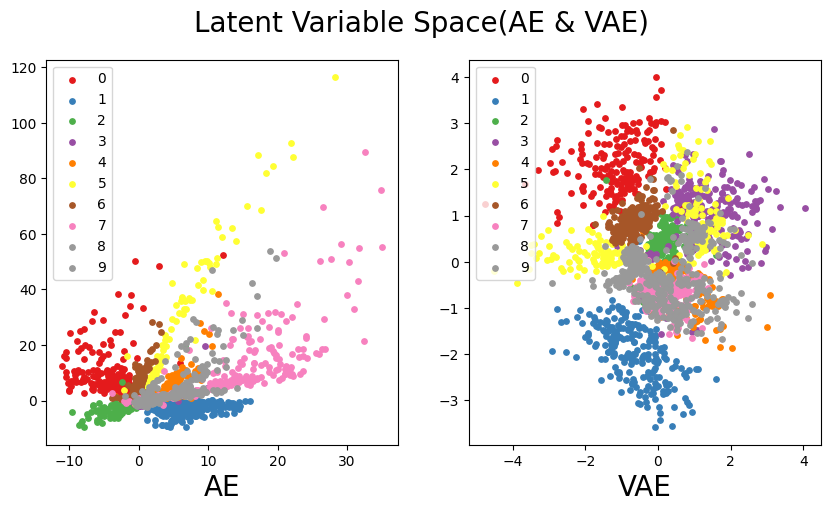

In [ ]:
#グラフの色の指定
map_keyword = "Set1"
cmap = plt.get_cmap(map_keyword)

#表示するバッチ番号の指定
batch_num = 9580

#グラフの設定
fig=plt.figure(figsize=[10,5])
plt.suptitle('Latent Variable Space(AE & VAE)',fontsize=20)

#train_loss_tensor = torch.stack(history_AE["train_loss"])
#train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
ax1 = fig.add_subplot(1, 2, 1)
for label in range(10):
  x = z_np_AE[batch_num:,:,0][labels_np_AE[batch_num:,:] == label]
  y = z_np_AE[batch_num:,:,1][labels_np_AE[batch_num:,:] == label]
  ax1.scatter(x, y, color=cmap(label/9), label=label, s=15)
  ax1.set_xlabel("AE",fontsize=20)
  #ax1.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
ax1.legend(loc="upper left")
ax2 = fig.add_subplot(1, 2, 2)
for label in range(10):
  x = z_np_VAE[batch_num:,:,0][labels_np_VAE[batch_num:,:] == label]
  y = z_np_VAE[batch_num:,:,1][labels_np_VAE[batch_num:,:] == label]
  ax2.scatter(x, y, color=cmap(label/9), label=label, s=15)
  ax2.set_xlabel("VAE",fontsize=20)
  #ax2.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
ax2.legend(loc="upper left")
plt.show()
plt.close()